<div dir='rtl'>
<h1>پروژه پنجم علوم اعصاب محاسباتی</h1>
<br/>
    - <font color='red'>با توجه به دشواری حفظ ساختار صورت پروژه در گزارش، آن ساختار نادیده گرفته شده و
    مطالب با ساختاری مناسب برای دنبال کردن نمودار‌ها و مطالب منظم شده‌اند؛ با اینحال تمام مطالب خواسته شده
    در صورت پروژه، در این گزارش پوشانده شده‌اند.</font>
<br/>
    - در این فاز. با توجه به حجم کم کد‌های گزارش (بجز قسمت اول که توابع مورد نیاز آورده شده است)، یکبار دیگر از تلاش برای حذف کد‌ها از گزارش چشم پوشی کردیم. این اصلاح در فاز‌های بعدی انجام خواهد شد.
<br/>
    - توضیحات نمودار‌ها زیر آن‌ها آورده شده است.
</div>

<div dir='rtl'>
<h2>0. فهرست مطالب</h2>
<ol>
    <li><a href="#1">توضیحات تکمیلی</a></li>
    <li><a href="#2">بررسی تصاویر</a></li>
    <li><a href="#3">مقایسه کلی روش‌ها</a></li>
    <li><a href="#4">تأثیر طول زمان شبیه‌سازی بر کیفیت روش‌ها</a></li>
    <li><a href="#5">تأثیر نرخ اسپایک روش پواسون</a></li>
    <li><a href="#6">تأثیر طول زمان شبیه‌سازی با نرخ اسپایک ثابت روش پواسون</a></li>
    <li><a href="#7">تأثیر تعداد نورون‌ها در روش جایگیری (اعداد)</a></li>
    <li><a href="#8">تأثیر انحراف معیار در روش جایگیری (اعداد)</a></li>
    <li><a href="#9">تغییر تصویر ورودی (روش زمان تا اولین اسپایک)</a></li>
</ol>
</div>

In [1]:
from cnsproject.network.encoders import *
from cnsproject.network.monitors import Monitor
from cnsproject.plotting.plotting import Plotter
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")
from matplotlib import image
from PIL import Image
import numpy as np

path1 = "image1.jpg"
path2 = "image2.jpeg"
path3 = "image3.jpg"

<div dir='rtl'>
<br/>
بجز ابزار شبیه‌سازی (که import شده‌اند)، توابع پایین در این تمرین خاص، برای شبیه‌سازی و مقایسه نورون‌ها در کنار هم به ما کمک خواهد کرد.
</div>

In [27]:
time = 20
def t2fs_encodding_check(p, im, time=time, postfix='', dt=1, name=''):
    enc = Time2FirstSpikeEncoder(shape=im.shape, max_input=255, length=time//dt)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s"], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    data = p.population_activity_raster('st'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.05)
    p.imshow('it'+postfix, enc.decode(enc_monitor['s'][1:]), cmap='YlGn', interpolation='nearest', title=name)
    return data
    
def poisson_encodding_check(p, im, time=time, postfix='', dt=1, name='', max_rate=time):
    enc = PoissonEncoder(shape=im.shape, max_input=255, length=time//dt, max_rate=max_rate)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s"], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    data = p.population_activity_raster('sp'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.02)
    p.imshow('ip'+postfix, enc.decode(enc_monitor['s'][1:]), cmap='YlGn', interpolation='nearest', title=name)
    return data
    
def position_encodding_check(p, im, time=time, postfix='', dt=1, name='', k=10, mean=None, std=None):
    enc = PositionEncoder(shape=im.shape, max_input=255, length=time//dt, k=k, mean=mean, std=std)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s",'stage'], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    data = p.population_activity_raster('sn'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.05)
    p.imshow('in'+postfix, enc.decode(enc_monitor['s'][1:]), cmap='YlGn', interpolation='nearest', title=name)
    return data
    
def raster_3d(subplot, xe, ye, shape, reduction=1, s=1, x_r=False, y_r=False, z_r=False, **args):
    ax = plt.subplot(subplot, projection='3d')
    ye = np.array(ye)
    ye = ye//reduction
    xd = (np.array(ye)//shape[0])
    yd = (np.array(ye)%shape[1])
    zd = np.array(xe)
    ax.scatter(xd, yd, zd, s=s, **args)
    axes = ax.axes
    if x_r:
        axes.invert_xaxis()
    if z_r:
        axes.invert_zaxis()
    if y_r:
        axes.invert_yaxis()
    ax.set_zlabel("time")

<a id='1'></a>
<div dir='rtl'>
<h2>1. توضیحات تکمیلی</h2>
<br/>
    در فرایند پیاده‌سازی این فاز، تصمیماتی در طراحی گرفته شده که در ادامه به آن‌ها اشاره خواهیم کرد:
    <br/>
    - انکودر را نوع خاصی از جمعیت نورونی (نورون‌های سنسوری) در نظر گرفته و با همان ساختار پیاده‌سازی کردیم. در نتیجه این تصمیم، مقدار زیادی از کد‌های گذشته باز استفاده شدند. همچنین از نگرانی درنظر گرفتن اجرا بر روی gpu و نگهداری از device خلاص شدیم.
    <br/>
    - برای بررسی عملکرد انکودر‌ها، در هر یک از آن‌ها متد دیکود تعبیه شده که سعی به تبدیل خروجی به ورودی می‌کند. در نمودار‌ها، این تصاویر خروجی نیز آورده شده‌اند. وجود نویز و کیفیت پایین در این تصاویر حاکی از دست رفتن داده در فرایند انکودینگ است.
    <br/>
    - نمودار فعالیت جمعیت نورونی در روش جایگیری (اعداد)، دارای تعداد نورون‌های بیشتری است (چون به هر پیکسل، بیش از یک نورون اختصاص می‌دهد). هنگام خواندن نمودار‌ها، این مسئله را مدنظر قرار دهید.
    <br/>
    - تمامی پارامتر‌های همه روش‌ها قابل تنظیم‌اند (حتی قابلیت تنظیم پارامتر پیکسل محور وجود دارد). در روش جایگیری (اعداد)، میانگین توزیع‌ها به صورت پیشفرض، به شکل linspace در رنج ورودی تنظیم شده است. همچنین انحراف معیار به صورت پیشفرض مقداری اختیار می‌کند که هر عدد توسط دو نورون پوشش داده شود. این پارامتر‌ها قابل تغییرند. تغییر انحراف معیار را بررسی خواهیم کرد.
    <br/>
    - برای حفظ حافظه‌ی اصلی، انکودر تمام اسپایک خروجی را به یکباره تولید نمی‌کند و گام به گام بخشی که نیاز است را تولید می‌کند. به همین دلیل برای دیکود، خروجی را از monitor می‌خوانیم.
    <br/>
    - نمودار‌های فعالیت جمعیت، جمعیت‌های نورونی را flatten کرده و سپس مورد بررسی قرار می‌دهند.
    <br/>
    - در برخی از بررسی‌ها، نمودار سه بعدی فعالیت جمعیت نورونی نیز رسم شده است.
</div>

<a id='2'></a>
<div dir='rtl'>
<h2>2. بررسی تصاویر</h2>
</div>

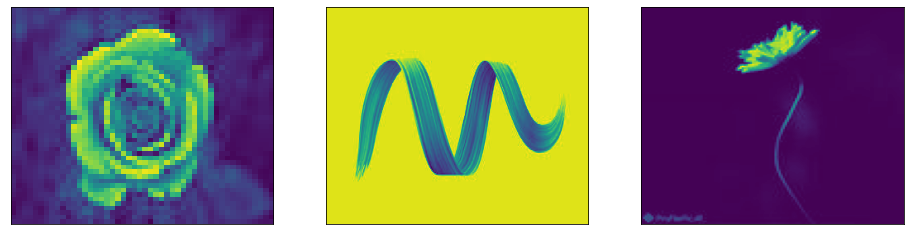

In [3]:
plt.figure(figsize=(16,4))
p = Plotter([
    ['im1','im2', 'im3'],
])
im1 = np.array(Image.open(path1).convert('L'))
gr_im1= Image.fromarray(im1)
p.imshow('im1', gr_im1)

im2 = np.array(Image.open(path2).convert('L'))
gr_im2= Image.fromarray(im2)
p.imshow('im2', gr_im2)

im3 = np.array(Image.open(path3).convert('L'))
gr_im3= Image.fromarray(im3)
p.imshow('im3', gr_im3)

plt.show()

<div dir='rtl'>
در طول این گزارش، به انکودینگ تصاویر بالا می‌پردازیم. بیشتر تأکید خود را بر تصویر سمت چپ خواهیم داشت. ابعاد این تصاویر از چپ به راست به ترتیب برابر:
    <br/>
    ۴۸×۴۸
    <br/>
    ۳۱۸×۱۵۹
    <br/>
    ۱۲۸×۱۲۸
    <br/>
    می‌باشد.
</div>

<a id='3'></a>
<div dir='rtl'>
<h2>3. مقایسه کلی روش‌ها</h2>
</div>

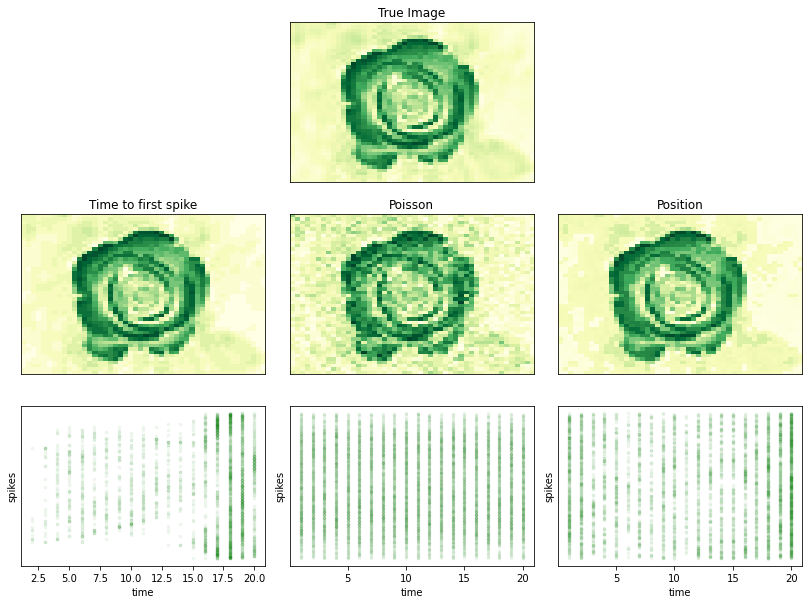

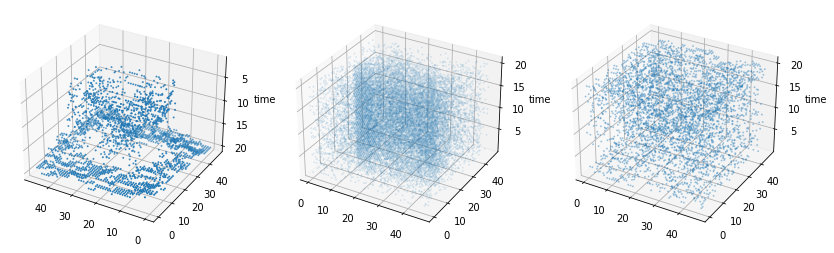

In [28]:
plt.figure(figsize=(14,10))
p = Plotter([
    [None, 'i',None],
    ['it','ip','in'],
    ['st','sp','sn'],
], wspace=0.1, hspace=0.2)

p.imshow('i', im1, "True Image", cmap='YlGn', interpolation='nearest')
d1 = t2fs_encodding_check(p,im1,name='Time to first spike')
d2 = poisson_encodding_check(p,im1,name='Poisson')
d3 = position_encodding_check(p,im1,name='Position')
p.show()

plt.figure(figsize=(14,5))
raster_3d('131', d1[0], d1[1], im1.shape, y_r=True, z_r=True)
raster_3d('132', d2[0], d2[1], im1.shape, alpha=.1)
raster_3d('133', d3[0], d3[1], im1.shape, reduction=10, alpha=.3)
plt.show()

<div dir='rtl'>
با توجه به نمودار‌های بالا، نتایج زیر قابل بحث‌اند:
    <br/>
    - بر خلاف دو روش دیگر، در روش فاصله زمانی تا اولین اسپایک، الگوی تصویر (شدت نور پیکسل‌ها) در رفتار جمعیت نورونی (هر دو نمودار دو بعدی و سه بعدی)، با چشم قابل تشخیص است. در تصویر سه بعدی می‌توند شکل برجسته‌ی گل را نیز متصور شد. در دو تصویر دیگر، به دلیل پیچیدگی منطق الگوریتم‌ها، این امکان وجود ندارد.
    <br/>
    - در روش پواسون، چون فعالیت‌های تصادفی وجود دارند، شاهد وجود نویز در تصویر بازیابی شده (دیکود شده) هستیم درحالی که در دو تصویر دیگر چنین چیزی مشاهده نمی‌کنیم. دلیل آن است که دو روش دیگر، توانایی دقت مشخصی دارند و هرگاه بیشتر از حدی نتوانند کیفیت تصویر را حفظ کنند، مقادیر نزدیک به هم را هم‌ارز می‌کنند )سمت راست تصویر  رنگ خود را از دست داده است) و دچار نویز تصادفی نمی‌شوند.
    <br/>
    -
   روش جایگیری (اعداد) بسیار موفق بوده اما نباید فراموش کنیم که این روش دارای تعداد نورون‌های بیشتری (ده برابر) است. 
</div>

<a id='4'></a>
<div dir='rtl'>
<h2>4. تأثیر طول زمان شبیه‌سازی بر کیفیت روش‌ها</h2>
</div>

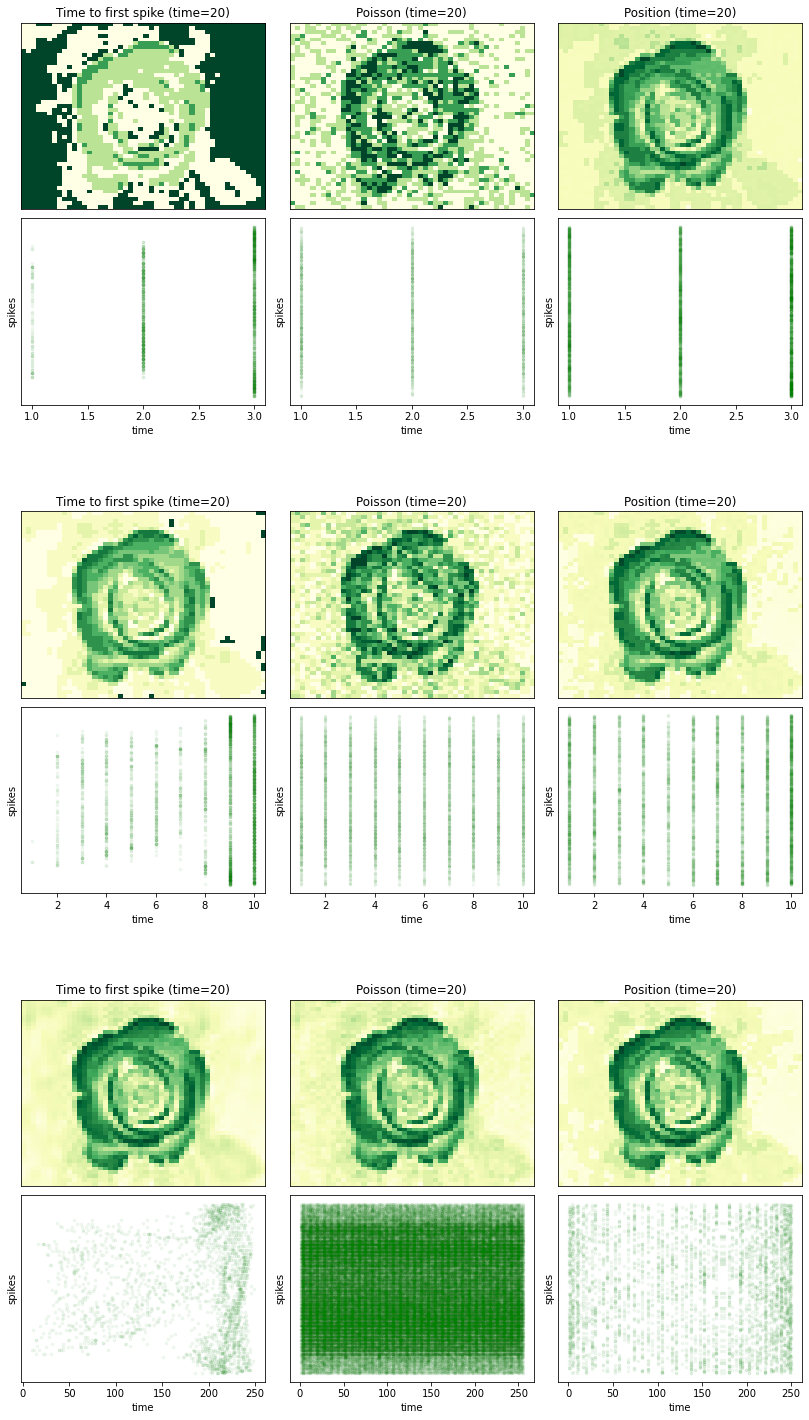

In [9]:
plt.figure(figsize=(14,25))
p = Plotter([
    ['it3','ip3','in3'],
    ['it3','ip3','in3'],
    ['st3','sp3','sn3'],
    ['st3','sp3','sn3'],
    [None,None,None],
    ['it10','ip10','in10'],
    ['it10','ip10','in10'],
    ['st10','sp10','sn10'],
    ['st10','sp10','sn10'],
    [None,None,None],
    ['it255','ip255','in255'],
    ['it255','ip255','in255'],
    ['st255','sp255','sn255'],
    ['st255','sp255','sn255'],
], wspace=0.1, hspace=0.1)

for t in [3,10,255]:
    t2fs_encodding_check(p,im1,name=f'Time to first spike (time={time})',postfix=str(t),time=t)
    poisson_encodding_check(p,im1,name=f'Poisson (time={time})',postfix=str(t),time=t,max_rate=t)
    enc = position_encodding_check(p,im1,name=f'Position (time={time})',postfix=str(t),time=t)
p.show()

<div dir='rtl'>
با توجه به نمودار‌های بالا، نتایج زیر قابل بحث‌اند:
    <br/>
    - در هر سه روش، بازه زمانی تأثیر بسزایی در کیفیت انکودر دارد چرا که هر سه انکودر ما از زمان بین اسپایک‌ها به عنوان فضای ذخیره سازی اطلاعات استفاده می‌کنند و داشتن زمان بیشتر به آن‌ها اجازه ورودی به جزئیات بیشتر می‌دهد.
    <br/>
    - تفاوت در نوع نقص در تصاویر حاصل از زمان کم جای بحث دارد. همانطور که در بخش قبل نیز توضیح داده شد، مدل پواسون دارای متغیر تصادفی بوده و به همین دلیل دچار نویز زیاد می‌شود. در عوض مدل اولی زمان تا اسپایک، به محوطه بندی‌های وسیع می‌پردازد. همچنان مدل جایگیری (اعداد) با قدرت حاضر شده که باز هم نباید تعداد بیشتر نورون‌ها را فراموش کنیم. این مدل علاوه بر زمان، از تنوع نورون‌های خود برای ذخیره اطلاعات استفاده می‌کند و به همین دلیل در برابر این ضعف مقاوم‌تر است.
</div>

<a id='5'></a>
<div dir='rtl'>
<h2>5. تأثیر نرخ اسپایک روش پواسون</h2>
</div>

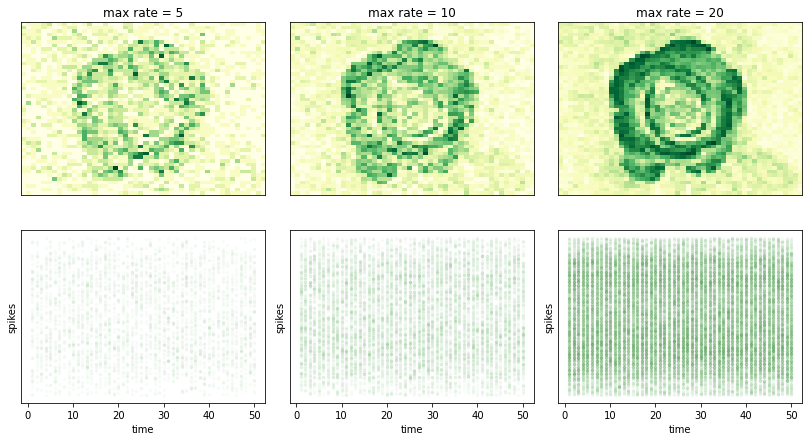

In [16]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['ip1','ip2','ip3'],
    ['sp1','sp2','sp3'],
], wspace=0.1, hspace=0.2)

d2 = poisson_encodding_check(p,im1,name='max rate = 5',postfix='1',max_rate=5, time=50)
d2 = poisson_encodding_check(p,im1,name='max rate = 10',postfix='2',max_rate=15, time=50)
d2 = poisson_encodding_check(p,im1,name='max rate = 20',postfix='3',max_rate=50, time=50)
p.show()

<div dir='rtl'>
واضح است که با افزایش این پارامتر، کیفیت مدل افزایش پیدا می‌کند چرا که اجازه‌ی استفاده بیشتر از پتانسیل ذخیره سازی اطالاعات خود را پیدا می‌کند. زمانی که نرخ اسپایک از حداکثر ممکن کمتر باشد، یعنی مدل فضایی که می‌تواند برای ذخیره سازی اطلاعات استفاده کند را دور می‌ریزد. سوال خوب آن است که وجود این فضای اضافی، اگر از آن استفاده نشود، می‌تواند مفید باشد؟ در بخش بعد به این سوال پاسخ خواهیم داد.
</div>

<a id='6'></a>
<div dir='rtl'>
<h2>6. تأثیر طول زمان شبیه‌سازی با نرخ اسپایک ثابت روش پواسون</h2>
</div>

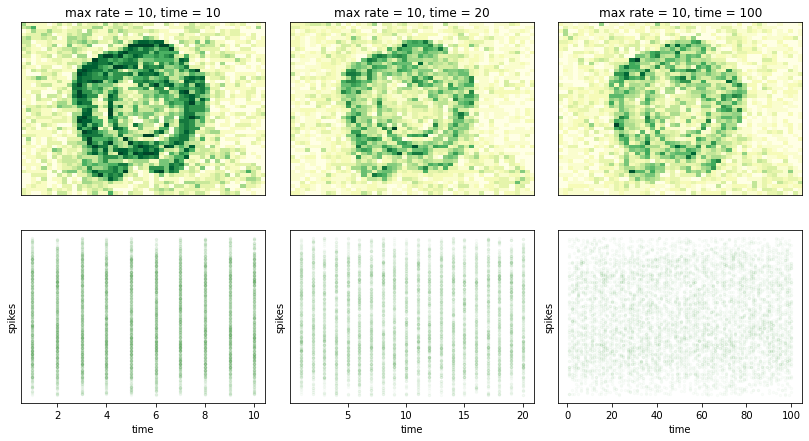

In [17]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['ip1','ip2','ip3'],
    ['sp1','sp2','sp3'],
], wspace=0.1, hspace=0.2)

d2 = poisson_encodding_check(p,im1,name='max rate = 10, time = 10',postfix='1', max_rate=10, time=10)
d2 = poisson_encodding_check(p,im1,name='max rate = 10, time = 20',postfix='2', max_rate=10, time=20)
d2 = poisson_encodding_check(p,im1,name='max rate = 10, time = 100',postfix='3', max_rate=10, time=100)
p.show()

<div dir='rtl'>
دیدن این نتیجه جالب است! وجود فضایی که از آن استفاده نمی‌شود، مضر است! دلیل آن است که این فضای اضافی به متغیر تصادفی مدل اجازه می‌دهد بیشتر از آنچه انتظار می‌رود، تصادفی عمل کند و این باعث ضعف در عملکرد مدل می‌شود.
</div>

<a id='7'></a>
<div dir='rtl'>
<h2>7. تأثیر تعداد نورون‌ها در روش جایگیری (اعداد)</h2>
</div>

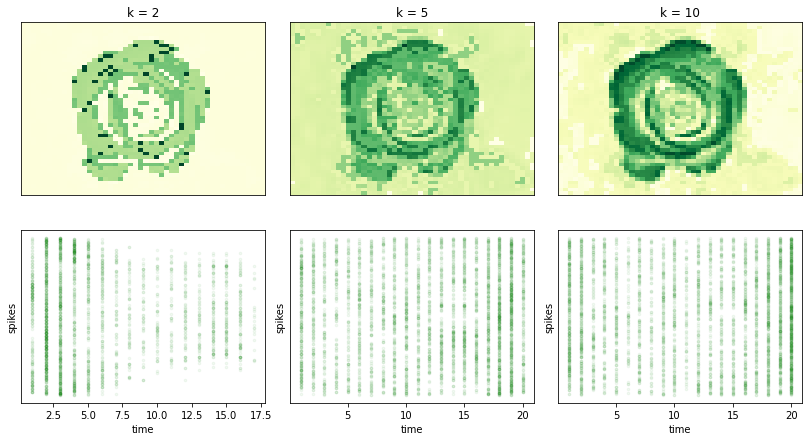

In [19]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['in1','in2','in3'],
    ['sn1','sn2','sn3'],
], wspace=0.1, hspace=0.2)

d2 = position_encodding_check(p,im1,name='k = 2', postfix='1', k=2)
d2 = position_encodding_check(p,im1,name='k = 5', postfix='2', k=5)
d2 = position_encodding_check(p,im1,name='k = 10', postfix='3', k=10)
p.show()

<div dir='rtl'>
تأثیر این پارامتر مشخص و قابل انتظار است. تعداد بیشتر نورون، فضای بیشتر ذخیره سازی اطلاعات به همراه می‌آورد. نکته با ارزش در این مشاهده آن است که نوع دقتی که این مدل در اثر کمبود نورون از دست می‌دهد، مانند مدل زمان تا اولین اسپایک است. به صورت دانسته، تنوع مقادیر کمتری را پوشش می‌دهد و خروجی به شکل ناحیه‌های وسیع قابل دسته‌بندی است. نکته قابل توجه دیگه آن است که هرچند این مدل با تعداد نورون بالا از همه مدل‌های دیگر بهتر عمل می‌کند، اما در مقایسه با مدل فاصله تا اولین اسپایک، با تعداد نورون برابر (یا حتی کمی بیشتر)، بسیار بدتر عمل می‌کند. دلیل این است که این مدل مقدار کمی از اطلاعات خود را در بعد زمان ذخیره می‌کند و بیشتر به تعداد نورون‌ها وابسته است. پیش‌تر نیز دیدیم که در زمان کم، این مدل بهتر کار می‌کرد. قوت دیگر این مدل پشتیبانی از مقادیر پیوسته است که در این مسئله کاربرد ندارد!
</div>

<a id='8'></a>
<div dir='rtl'>
<h2>8. تأثیر انحراف معیار در روش جایگیری (اعداد)</h2>
</div>

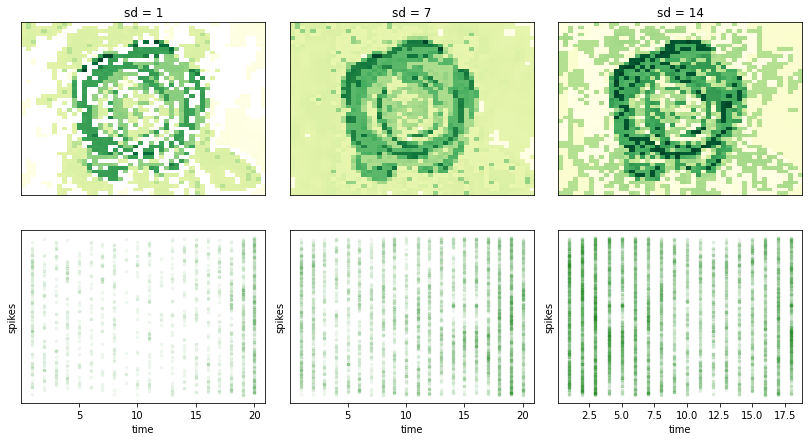

In [24]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['in1','in2','in3'],
    ['sn1','sn2','sn3'],
], wspace=0.1, hspace=0.2)

d2 = position_encodding_check(p,im1,name='sd = 1', postfix='1', k=5, std=8.)
d2 = position_encodding_check(p,im1,name='sd = 7', postfix='2', k=5, std=20.)
d2 = position_encodding_check(p,im1,name='sd = 14', postfix='3', k=5, std=50.)
p.show()

<div dir='rtl'>
می‌بینیم که مقدار این پارامتر تأثیر بسزایی در عملکرد مدل دارد. دلیل این امر آن است که انحراف معیار توزیع نورون‌ها باعث هماهنگی و همپوشانی مناسب یا نامناسب آن‌ها و در نتیجه، بهره‌وری بهینه یا غیر بهینه از اسپایک‌ها می‌شود. یافتن مقدار مناسب برای این پارامتر بسیار حیاتی است.
</div>

<a id='9'></a>
<div dir='rtl'>
<h2>9. تغییر تصویر ورودی (روش زمان تا اولین اسپایک)</h2>
</div>

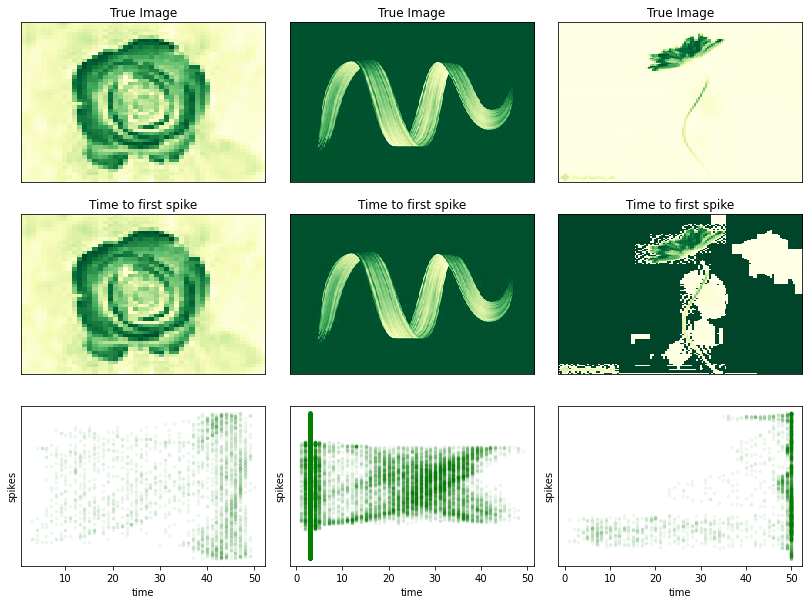

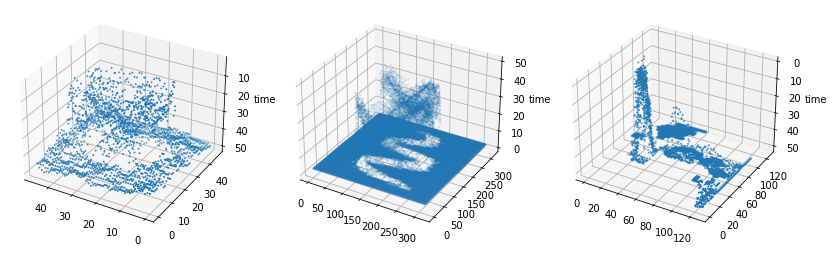

In [40]:
plt.figure(figsize=(14,10))
p = Plotter([
    ['i1', 'i2', 'i3'],
    ['it1','it2','it3'],
    ['st1','st2','st3'],
], wspace=0.1, hspace=0.2)

p.imshow('i1', im1, "True Image", cmap='YlGn', interpolation='nearest')
p.imshow('i2', im2, "True Image", cmap='YlGn', interpolation='nearest')
p.imshow('i3', im3, "True Image", cmap='YlGn', interpolation='nearest')

d1 = t2fs_encodding_check(p,im1,name='Time to first spike',postfix='1',time=50)
d2 = t2fs_encodding_check(p,im2,name='Time to first spike',postfix='2',time=50)
d3 = t2fs_encodding_check(p,im3,name='Time to first spike',postfix='3',time=50)
p.show()

plt.figure(figsize=(14,5))
raster_3d('131', d1[0], d1[1], im1.shape, y_r=True, z_r=True)
raster_3d('132', d2[0], d2[1], im2.shape, alpha=.1)
raster_3d('133', d3[0], d3[1], im3.shape, z_r=True)
plt.show()

<div dir='rtl'>
- مشاهده‌ی الگوی تصاویر در فعالیت جمعیت نورونی بسیار ساده است.
    <br/>
    - تصویر وسط به دلیل پشت زمینه روش، تعداد اسپایک‌های زیادی در لحظه صفر ایجاد کرده است. همچنین طرح تصویر به وضوع در شکل سه بعدی دیده می‌شود.
    <br/>
    تصویر سوم به دلیل ابعاد زیاد، مشکلاتی در انکودینگ ایجاد کرده و مدل قادل به انکود کامل آن نشده.
</div>